## <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Domain: Face Recognition

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Problem Description:
<font color=darkblue>
The goal is to build a face identification model to recognize faces.
</font> 

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Dataset:
<font color=darkblue>Aligned Face Dataset from Pinterest
<br>
This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.
<br>
</font> 

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Overview:
<font color=darkblue>
Here, we are particularly interested in recognizing whether two given faces are of the same person or not. Below are the steps involved in the project
</font>

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Objective:
<font color=darkblue>In this problem, we use a pre-trained model trained on Face recognition to recognize similar faces. Here, we are particularly interested in recognizing whether two given faces are of the same person or not
</font>

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Model
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score
from scipy.spatial import distance

import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
print('Tensorflow Version : ', tf.__version__)
print('Numpy Version : ', np.__version__)
print('Pandas Version : ', pd.__version__)
print('Matplotlib Version : ', matplotlib.__version__)


Tensorflow Version :  2.4.0
Numpy Version :  1.19.4
Pandas Version :  1.1.5
Matplotlib Version :  3.2.2


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Change current working directory to project folder

In [4]:
images_path = "/content/drive/MyDrive/AIML/Projects/"
images_zip_file = "Aligned Face Dataset from Pinterest.zip"


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Extract the zip file :
<font color=darkblue>
Extract Aligned Face Dataset from Pinterest.zip
<ul>
</ul>
</font>

In [5]:
from zipfile import ZipFile
with ZipFile(images_path + images_zip_file, 'r') as zip:
  zip.extractall()

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Load Images :
<font color=darkblue>
Define a function to load the images from the extracted folder and map each image with person id
<ul>
</ul>
</font>

In [6]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [7]:
metadata.shape

(10770,)

In [8]:
metadata[0:10]

array([PINS/pins_shakira/shakira40.jpg, PINS/pins_shakira/shakira18.jpg,
       PINS/pins_shakira/shakira24.jpg, PINS/pins_shakira/shakira16.jpg,
       PINS/pins_shakira/shakira45.jpg, PINS/pins_shakira/shakira6.jpg,
       PINS/pins_shakira/shakira7.jpg, PINS/pins_shakira/shakira22.jpg,
       PINS/pins_shakira/shakira47.jpg, PINS/pins_shakira/shakira14.jpg],
      dtype=object)

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Define function to load image :
<font color=darkblue>
Define a function to load image from the metadata
<ul>
</ul>
</font>

In [9]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Load a sample image :
<font color=darkblue>
Load one image using the function load_image
<ul>
</ul>
</font>

In [10]:
print(metadata[1].file)

shakira18.jpg


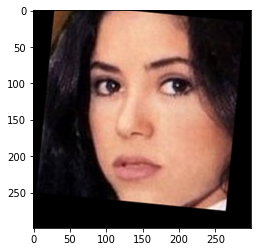

In [11]:
img = load_image(metadata[1].image_path())
plt.figure()
plt.imshow(img)


In [12]:
print(metadata[111].file)

dua lipa face105.jpg


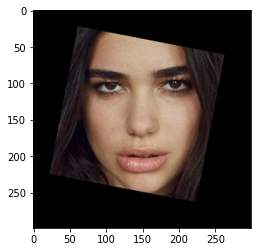

In [13]:
img = load_image(metadata[111].image_path())
plt.figure()
plt.imshow(img)


In [14]:
print(metadata[211].file)

rihanna105.jpg


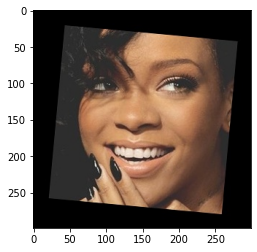

In [15]:
img = load_image(metadata[211].image_path())
plt.figure()
plt.imshow(img)


In [16]:
print(metadata[311].file)

Mark Ruffalo73.jpg


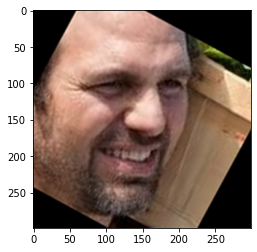

In [17]:
img = load_image(metadata[311].image_path())
plt.figure()
plt.imshow(img)

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">VGG Face model :
<font color=darkblue>
<ul>
</ul>
</font>

In [18]:

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Load the model :
<font color=darkblue>
Load the model defined above
<br>
Then load the given weight file named "vgg_face_weights.h5"
<ul>
</ul>
</font>

In [19]:
model = vgg_face()

In [20]:
model.load_weights('/content/drive/MyDrive/AIML/Projects/vgg_face_weights.h5')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Get vgg_face_descriptor :
<font color=darkblue>
<ul>
</ul>
</font>

In [22]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Generate embeddings for each image in the dataset :
<font color=darkblue>
Load the first image in the metadata and get its embedding vector from the pre-trained model
<ul>
</ul>
</font>

In [23]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Generate embeddings for all images :
<font color=darkblue>
Write code to iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings.
<br><br>
If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.
<ul>
</ul>
</font>

In [24]:
embeddings = np.zeros((metadata.shape[0],2622))

for i, m in enumerate(metadata):
  img_path = m.image_path()
  img = load_image(img_path)

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)
  img = cv2.resize(img, dsize = (224,224))
  #embeddings[i] = model.predict(np.expand_dims(img, axis=0))[0]
  embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

  # obtain embedding vector for image
  embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]


In [25]:
embeddings.shape, embedding_vector.shape


((10770, 2622), (2622,))

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Function to calculate distance between given 2 pairs of images :
<font color=darkblue>
Consider distance metric as "Squared L2 distance"
<br>
Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2
<ul>
</ul>
</font>


In [26]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Plot images and get distance between the pairs given below :
<font color=darkblue>
<ul>
<li>2, 3 and 2, 180</li>
<li>30, 31 and 30, 100</li>
<li>70, 72 and 70, 115</li>
</ul>
</font>

In [27]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    



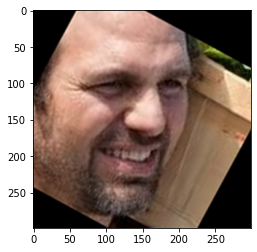

In [28]:
img = load_image(metadata[311].image_path())
plt.figure()
plt.imshow(img)

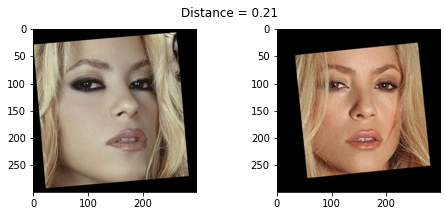

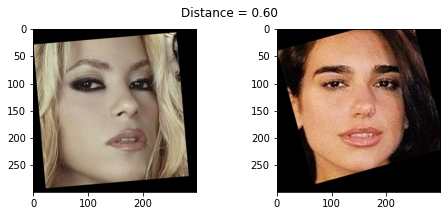

In [29]:
show_pair(2, 3)
show_pair(2, 180)

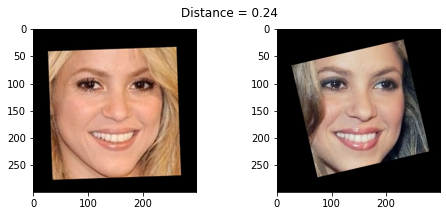

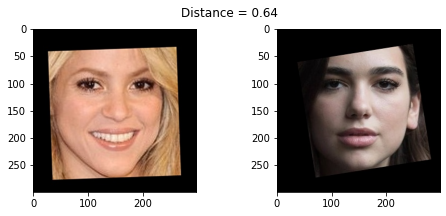

In [30]:
show_pair(30, 31)
show_pair(30, 100)


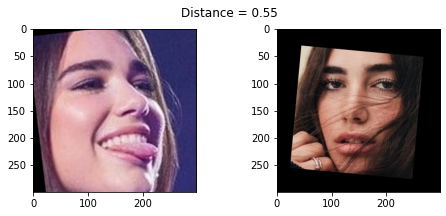

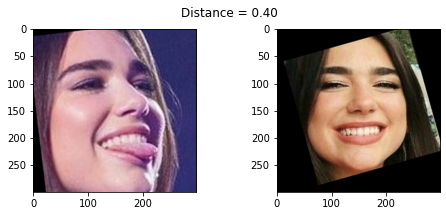

In [31]:
show_pair(70, 72)
show_pair(70, 115)


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Create train and test sets :
<font color=darkblue>
<ul>
<li>Create X_train, X_test and y_train, y_test</li>
<li>Use train_idx to seperate out training features and labels</li>
<li>Use test_idx to seperate out testing features and labels</li>
</ul>
</font>

In [32]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0 #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

X_train = embeddings[train_idx]         # one half as train examples of 10 identities
X_test = embeddings[test_idx]           # another half as test examples of 10 identities

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]    #train labels
y_test = targets[test_idx]      #test labels


In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(9573, 2622)
(9573,)
(1197, 2622)
(1197,)


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Encode the Labels :
<font color=darkblue>
<ul>
<li>Encode the targets</li>
<li>Use LabelEncoder</li>
</ul>
</font>

In [34]:
encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y_train = encoder.transform(targets[train_idx])
y_test = encoder.transform(targets[test_idx])

In [35]:
y_train

array([95, 95, 95, ..., 32, 32, 32])

In [36]:
y_test

array([95, 95, 95, ..., 32, 32, 32])

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Standardize the feature values :
<font color=darkblue>
<ul>
<li>Scale the features using StandardScaler</li>
</ul>
</font>

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Reduce dimensions using PCA :
<font color=darkblue>
<ul>
<li>Reduce feature dimensions using Principal Component Analysis</li>
<li>Set the parameter n_components=128</li>
</ul>
</font>

In [38]:
# PCA

pca = PCA(n_components=128)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [39]:
X_train.shape, X_test.shape

((9573, 128), (1197, 128))

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Build a Classifier :
<font color=darkblue>
<ul>
<li>Use SVM Classifier to predict the person in the given image</li>
<li>Fit the classifier and print the score</li>
</ul>
</font>

In [40]:
# SVM Classifier

svc = LinearSVC()
svc.fit(X_train, y_train)
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('SVM accuracy = ', acc_svc)

SVM accuracy =  0.9582289055973267


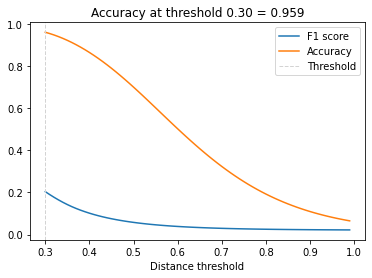

In [41]:
distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embeddings[i], embeddings[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

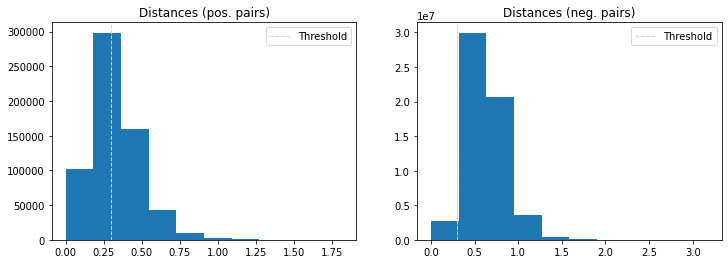

In [42]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [43]:
# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

X_train = embeddings[train_idx]		# 50 train examples of 10 identities (5 examples each)
X_test = embeddings[test_idx]		# 50 test examples of 10 identities (5 examples each)

y_train = y[train_idx]
y_test = y[test_idx]

svc = LinearSVC()
svc.fit(X_train, y_train)
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'SVM accuracy = {acc_svc}')


SVM accuracy = 0.966016713091922


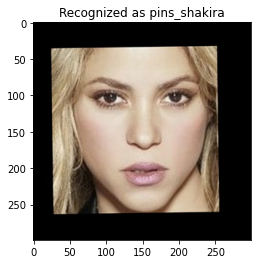

In [44]:
example_idx = 6

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embeddings[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');


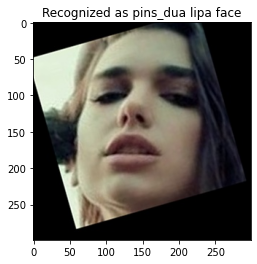

In [45]:
example_idx = 55

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embeddings[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');


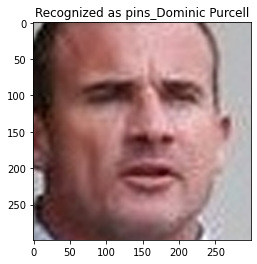

In [46]:
example_idx = 456

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embeddings[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Test results :
<font color=darkblue>
<ul>
<li>Take 10th image from test set and plot the image</li>
<li>Report to which person(folder name in dataset) the image belongs to</li>
</ul>
</font>

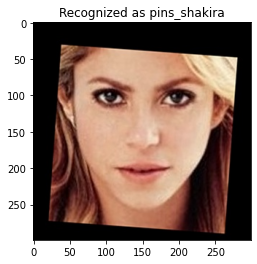

In [47]:
example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embeddings[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');


Text(0.5, 1.0, 'Predicted :[95]')

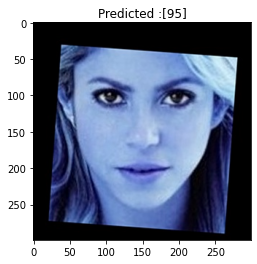

In [48]:
plt.imshow(cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB))
plt.title('Predicted :' + str(example_prediction))

#### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Conclusion :
<font color=darkblue>
Goal is to build a face identification model to recognize faces. We Extracted the PINS zip file. Loaded the images. Created a model on vgg_face. Loaded the weights from vgg_face_weights.h5, generated embeddings for all images. plotted the images and got the distance between 2 given points. Created Train and Test data sets. Encoded the labels using LabelEncoder. Reduced the dimensions using PCA. Built a SVM classifier model and predicted for a given image. Tested for a given image on SVM classifier model.
</font>